In [6]:
#Borrador de mi codigo con correciones
import numpy as np
import math
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import random
from mpl_toolkits.mplot3d import Axes3D
from multiprocessing import Pool, cpu_count
import time
import logging

#Ion: Yb+ , atom: Li

#constants
m_ion = 2.8733965E-25  #(YB+) 2,8733965 × 10^-25 kg (SR+ 2.83E-25)
m_atom = 1.1525801E-26 # (LITIO) 1,1525801 × 10^-26 kg (RB 1.44E-25 )
C4=5.607E-57   #C4=5.607E-57   Paper Prospects #C4=1.1E-56 RbSr+
C6=5E-19 * C4   #C6=5.0E-19     Paper Prospects (LIYB+) C6 = 2.803 × 10−75 Jm6 C4 = 2.803 × 10−57
frf = 2.5 * 10**6
Omega= 2 * np.pi * frf #MHz #Depende tambien mucho de esta fase
a = -2.982E-4  #-3E-7, da un buen comportamiento
q = 0.1      #Entre 0.1 y otro
T_ion =  0 # da un buen comportamiento  0.5 milikelvin   Paper Ziv Meir (de Jesus)
T_atom = 0.1E-6  #0.1E-6, da un buen comportamiento   #6 microkelvin (mucho más frio átomo que ion) Paper Ziv Meir
r0 = 0.1E-6
ti= 0
tf= 10E-6          #0.001, da un buen comportamiento pal ion #de matlab 200e-6; SE PUEDE CAMBIAR A 200
dt= 1000
ptol = 1e-10
kB = 1.38064E-23
e = -1.6E-19
num_cpus = 24
num_solution = 1
num_collisions = 500
Eff = (0.01 * e ) / m_ion

logging.basicConfig(level=logging.INFO)

def system(t, y, a, q, Omega, C4, C6, m_ion, m_a):

    ionx, iony, ionz, ionvx, ionvy, ionvz, atomx, atomy, atomz, atomvx, atomvy, atomvz = y

    # Definición de las ecuaciones diferenciales
    dydt = np.zeros_like(y)

    #Velocidades del ion
    dydt[0] = ionvx
    dydt[1] = ionvy
    dydt[2] = ionvz

    #velocidades del átomo
    dydt[6] = atomvx
    dydt[7] = atomvy
    dydt[8] = atomvz

    #Potencial para el ion
    dydt[3] = -(a+2*q*np.cos(Omega*t)) *ionx*(Omega**2 / 4)
    dydt[4] = -(a+2*q*np.cos(Omega*t)) *iony*(Omega**2 / 4)
    dydt[5] = -(2*a+2*-q*np.cos(Omega*t)) *ionz*(Omega**2 / 4)

    #Interacción con el potencial atom
    r = np.sqrt((atomx - ionx)**2 + (atomy - iony)**2 + (atomz - ionz)**2)

    dydt[3] += -(2*C4/r**5 -6 *C6 / r**7) * (ionx - atomx) / (m_ion * r)
    dydt[4] += -(2*C4/r**5 -6 *C6 / r**7) * (iony - atomy) / (m_ion * r)
    dydt[5] += -(2*C4/r**5 -6 *C6 / r**7) * (ionz - atomz) / (m_ion * r)

    dydt[9] += -(2*C4/r**5 -6 *C6 / r**7) * (atomx - ionx) / (m_atom * r)
    dydt[10] += -(2*C4/r**5 -6 *C6 / r**7) * (atomy - iony) / (m_atom * r)
    dydt[11] += -(2*C4/r**5 -6 *C6 / r**7) * (atomz - ionz) / (m_atom * r)

    return dydt

#Funciones
def position_on_sphere(radius):
    phi = 2 * np.pi * np.random.rand()
    theta = np.arccos(2 * np.random.rand() - 1)
    # Convertir a coordenadas cartesianas
    x = radius * np.sin(theta) * np.cos(phi)
    y = radius * np.sin(theta) * np.sin(phi)
    z = radius * np.cos(theta)
    return x, y, z

def velocidad_atom(temperature, mass, x, y, z):
    phi = 2 * np.pi * np.random.rand()
    theta = np.arccos(2 * np.random.rand() - 1)

    kb = 1.380649e-23  # Constante de Boltzmann en m^2 kg s^-2 K^-1

    # Spherical velocities
    v_theta = np.sqrt((2 * kb * temperature) / mass) * random.gauss(0, 1)
    v_phi = np.sqrt((2 * kb * temperature) / mass) * random.gauss(0, 1)
    v_r = -abs(np.random.weibull(2) * np.sqrt(2 * kb * temperature / mass))

    # Componentes de velocidad en coordenadas cartesianas
    v_x = v_r * np.sin(theta) * np.cos(phi) + v_theta * np.cos(theta) * np.cos(phi) - v_phi * np.sin(phi)
    v_y = v_r * np.sin(theta) * np.sin(phi) + v_theta * np.cos(theta) * np.sin(phi) + v_phi * np.cos(phi)
    v_z = v_r * np.cos(theta) - v_theta * np.sin(theta)

    return v_x, v_y, v_z

def velocidad_ion(temperature, mass):
    kb = 1.38064E-23  # Constante de Boltzmann en m^2 g s^-2 K^-1, kelvin, metros, segundos, kilogramos
    v = np.sqrt((2 * kb * temperature) / mass) * random.gauss(0, 1)
    return v

# Definición del vector de tiempo
t_span = (ti, tf)

# Resolución del sistema de ecuaciones diferenciales
def run_simulation(i):

    ionx_0=0.0
    iony_0=0.0
    ionz_0=0.0
    ionvx_0=velocidad_ion(T_ion, m_ion)
    ionvy_0=velocidad_ion(T_ion, m_ion)
    ionvz_0=velocidad_ion(T_ion, m_ion)
    atomx_0, atomy_0, atomz_0 = position_on_sphere(r0)
    atomvx_0, atomvy_0, atomvz_0 = velocidad_atom(T_atom, m_atom, atomx_0, atomy_0, atomz_0)
    y0 = [ionx_0, iony_0, ionz_0, ionvx_0, ionvy_0, ionvz_0, atomx_0, atomy_0, atomz_0, atomvx_0, atomvy_0, atomvz_0]

    results = []

    for collision in range (num_collisions):
          #inicialization variables
        solution = solve_ivp(system, t_span, y0, t_eval=np.linspace(t_span[0], t_span[1], dt), method='RK45', args=(a, q, Omega, C4, C6, m_ion, m_atom), rtol=ptol)

        # Extracción de las soluciones temporales
        t_sol = solution.t
        ionx_sol = solution.y[0]
        iony_sol = solution.y[1]
        ionz_sol = solution.y[2]
        ionvx_sol = solution.y[3]
        ionvy_sol = solution.y[4]
        ionvz_sol = solution.y[5]
        atomx_sol = solution.y[6]
        atomy_sol = solution.y[7]
        atomz_sol = solution.y[8]
        atomvx_sol = solution.y[9]
        atomvy_sol = solution.y[10]
        atomvz_sol = solution.y[11]

        results.append([t_sol, ionx_sol, iony_sol, ionz_sol, ionvx_sol, ionvy_sol, ionvz_sol, atomx_sol, atomy_sol, atomz_sol, atomvx_sol, atomvy_sol, atomvz_sol])

        #Se actulizan las condiciones para el ion y el atomo
        atomx_0, atomy_0, atomz_0 = position_on_sphere(r0)
        atomvx_0, atomvy_0, atomvz_0 = velocidad_atom(T_atom, m_atom, atomx_0, atomy_0, atomz_0)
        y0 = [ionx_sol[-1], iony_sol[-1], ionz_sol[-1], ionvx_sol[-1], ionvy_sol[-1], ionvz_sol[-1], atomx_0, atomy_0, atomz_0, atomvx_0, atomvy_0, atomvz_0]

    return results

if __name__ == '__main__':

    logging.info("Inicio de la ejecución")
    start_time = time.time()
    with Pool(processes=num_cpus) as pool:
        all_results = pool.map(run_simulation, range(num_solution))
    
    end_time = time.time()
    execution_time = (end_time - start_time)/60
    logging.info("Ejecución completada")
    print(f"Tiempo total de ejecución con 24 nucleos: {execution_time:.2f}minutos")

INFO:root:Inicio de la ejecución


INFO:root:Ejecución completada


Tiempo total de ejecución con 24 nucleos: 2.04minutos


In [ ]:
for i, results in enumerate (all_results):   #cada colision en numero de trayectorias
    for j, result in enumerate (results):     #parametros de cada colision
        t_sol=result[0]
        ionx_sol=result[1]
        iony_sol=result[2]
        ionz_sol=result[3]
        ionvx_sol=result[4]
        ionvy_sol=result[5]
        ionvz_sol=result[6]
        atomx_sol=result[7]
        atomy_sol=result[8]
        atomz_sol=result[9]
        atomvx_sol=result[10]
        atomvy_sol=result[11]
        atomvz_sol=result[12]

        plt.plot(ionx_sol, iony_sol)
        plt.plot(atomx_sol, atomy_sol)
        plt.xlim(-2E-7, 2E-7)
        plt.ylim(-1E-6, 1E-6)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.show()

In [ ]:
#Debe graficarse en relación al tiempo
R = []
for i in range(1000):
  R.append(np.sqrt((atomx_sol[i] - ionx_sol[i])**2 + (atomy_sol[i] - iony_sol[i])**2 + (atomz_sol[i] - ionz_sol[i])**2))

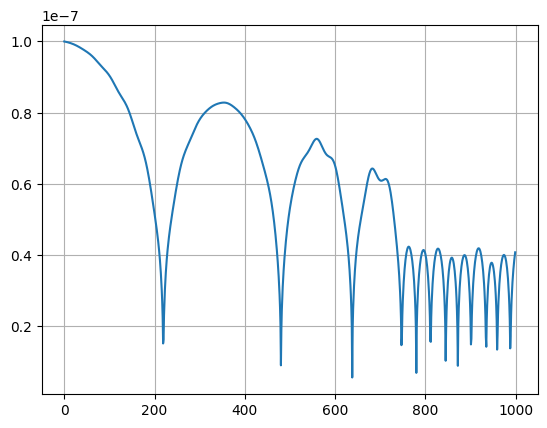

In [ ]:

plt.plot(R)
plt.grid()

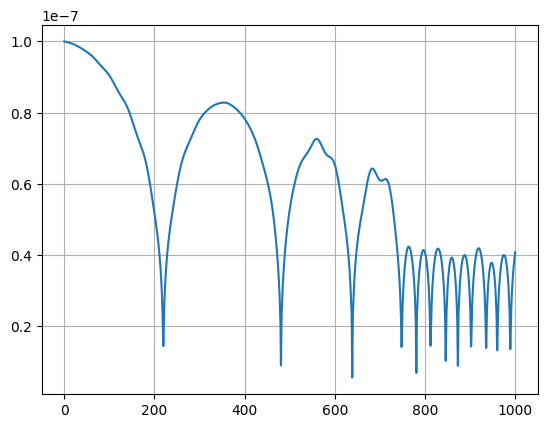

In [ ]:
from scipy.interpolate import CubicSpline
x_grid = np.linspace(0,1000,1000)
R_t = CubicSpline(x_grid,R)
x_grid2 = np.linspace(0,1000,1000000)
R2 = R_t(x_grid2)
plt.plot(x_grid2, R2)
plt.grid()

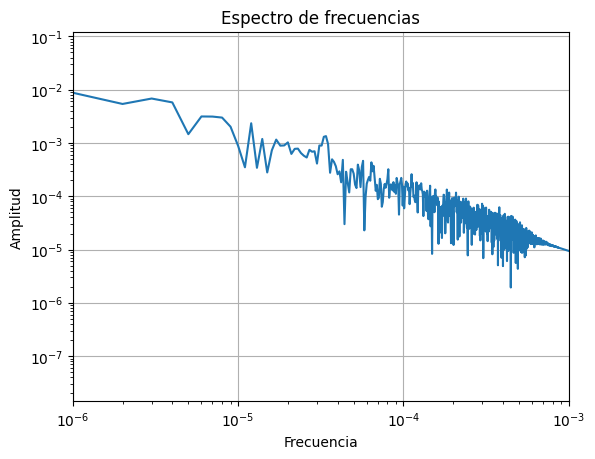

In [ ]:
#AAplicación FFT
N = len(R2)
y_fft= np.fft.fft(R2)
x_fft= np.fft.fftfreq(len(R2))[:N//2]

#Graficas en dominio de frecuencias
plt.plot(x_fft, np.abs(y_fft[:N//2]))
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-6, 1e-3)
plt.xlabel('Frecuencia')
plt.ylabel('Amplitud')
plt.title('Espectro de frecuencias')
plt.grid()
plt.show()

In [6]:
#Caracterización de resonancias en la trampa
import numpy as np
import math
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import random
from mpl_toolkits.mplot3d import Axes3D
from multiprocessing import Pool, cpu_count
import time
import logging

#Ion: Yb+ , atom: Li

#constants
m_ion = 2.8733965E-25  #(YB+) 2,8733965 × 10^-25 kg (SR+ 2.83E-25)
m_atom = 1.1525801E-26 # (LITIO) 1,1525801 × 10^-26 kg (RB 1.44E-25 )
C4=5.607E-57   #C4=5.607E-57   Paper Prospects #C4=1.1E-56 RbSr+
C6=5E-19 * C4   #C6=5.0E-19     Paper Prospects (LIYB+) C6 = 2.803 × 10−75 Jm6 C4 = 2.803 × 10−57
frf = 2.5 * 10**6
Omega= 2 * np.pi * frf #MHz #Depende tambien mucho de esta fase
a = 0.0  #-3E-7, da un buen comportamiento
q = 0.0      #Entre 0.1 y otro
T_ion =  0 # da un buen comportamiento  0.5 milikelvin   Paper Ziv Meir (de Jesus)
T_atom = 0.1E-6  #0.1E-6, da un buen comportamiento   #6 microkelvin (mucho más frio átomo que ion) Paper Ziv Meir
r0 = 0.1E-6
ti= 0
tf= 10E-6          #0.001, da un buen comportamiento pal ion #de matlab 200e-6; SE PUEDE CAMBIAR A 200
dt= 1000
ptol = 1e-10
kB = 1.38064E-23
e = -1.6E-19
num_cpus = 24
num_solution = 3
num_collisions = 5

logging.basicConfig(level=logging.INFO)

def system(t, y, a, q, Omega, C4, C6, m_ion, m_a):

    ionx, iony, ionz, ionvx, ionvy, ionvz, atomx, atomy, atomz, atomvx, atomvy, atomvz = y

    # Definición de las ecuaciones diferenciales
    dydt = np.zeros_like(y)

    #Velocidades del ion
    dydt[0] = ionvx
    dydt[1] = ionvy
    dydt[2] = ionvz

    #velocidades del átomo
    dydt[6] = atomvx
    dydt[7] = atomvy
    dydt[8] = atomvz

    #Potencial para el ion
    dydt[3] = -(a+2*q*np.cos(Omega*t)) *ionx*(Omega**2 / 4)
    dydt[4] = -(a+2*q*np.cos(Omega*t)) *iony*(Omega**2 / 4)
    dydt[5] = -(2*a+2*-q*np.cos(Omega*t)) *ionz*(Omega**2 / 4)

    #Interacción con el potencial atom
    r = np.sqrt((atomx - ionx)**2 + (atomy - iony)**2 + (atomz - ionz)**2)

    dydt[3] += -(2*C4/r**5 -6 *C6 / r**7) * (ionx - atomx) / (m_ion * r)
    dydt[4] += -(2*C4/r**5 -6 *C6 / r**7) * (iony - atomy) / (m_ion * r)
    dydt[5] += -(2*C4/r**5 -6 *C6 / r**7) * (ionz - atomz) / (m_ion * r)

    dydt[9] += -(2*C4/r**5 -6 *C6 / r**7) * (atomx - ionx) / (m_atom * r)
    dydt[10] += -(2*C4/r**5 -6 *C6 / r**7) * (atomy - iony) / (m_atom * r)
    dydt[11] += -(2*C4/r**5 -6 *C6 / r**7) * (atomz - ionz) / (m_atom * r)

    return dydt

#Funciones
def position_on_sphere(radius):
    phi = 2 * np.pi * np.random.rand()
    theta = np.arccos(2 * np.random.rand() - 1)
    # Convertir a coordenadas cartesianas
    x = radius * np.sin(theta) * np.cos(phi)
    y = radius * np.sin(theta) * np.sin(phi)
    z = radius * np.cos(theta)
    return x, y, z

def velocidad_atom(temperature, mass, x, y, z):
    phi = 2 * np.pi * np.random.rand()
    theta = np.arccos(2 * np.random.rand() - 1)

    kb = 1.380649e-23  # Constante de Boltzmann en m^2 kg s^-2 K^-1

    # Spherical velocities
    v_theta = np.sqrt((2 * kb * temperature) / mass) * random.gauss(0, 1)
    v_phi = np.sqrt((2 * kb * temperature) / mass) * random.gauss(0, 1)
    v_r = -abs(np.random.weibull(2) * np.sqrt(2 * kb * temperature / mass))

    # Componentes de velocidad en coordenadas cartesianas
    v_x = v_r * np.sin(theta) * np.cos(phi) + v_theta * np.cos(theta) * np.cos(phi) - v_phi * np.sin(phi)
    v_y = v_r * np.sin(theta) * np.sin(phi) + v_theta * np.cos(theta) * np.sin(phi) + v_phi * np.cos(phi)
    v_z = v_r * np.cos(theta) - v_theta * np.sin(theta)

    return v_x, v_y, v_z

def velocidad_ion(temperature, mass):
    kb = 1.38064E-23  # Constante de Boltzmann en m^2 g s^-2 K^-1, kelvin, metros, segundos, kilogramos
    v = np.sqrt((2 * kb * temperature) / mass) * random.gauss(0, 1)
    return v

# Definición del vector de tiempo
t_span = (ti, tf)

# Resolución del sistema de ecuaciones diferenciales
def run_simulation(i):

    ionx_0=0.0
    iony_0=0.0
    ionz_0=0.0
    ionvx_0=velocidad_ion(T_ion, m_ion)
    ionvy_0=velocidad_ion(T_ion, m_ion)
    ionvz_0=velocidad_ion(T_ion, m_ion)
    atomx_0, atomy_0, atomz_0 = position_on_sphere(r0)
    atomvx_0, atomvy_0, atomvz_0 = velocidad_atom(T_atom, m_atom, atomx_0, atomy_0, atomz_0)
    y0 = [ionx_0, iony_0, ionz_0, ionvx_0, ionvy_0, ionvz_0, atomx_0, atomy_0, atomz_0, atomvx_0, atomvy_0, atomvz_0]

    results = []

    for collision in range (num_collisions):
          #inicialization variables
        solution = solve_ivp(system, t_span, y0, t_eval=np.linspace(t_span[0], t_span[1], dt), method='RK45', args=(a, q, Omega, C4, C6, m_ion, m_atom), rtol=ptol)

        # Extracción de las soluciones temporales
        t_sol = solution.t
        ionx_sol = solution.y[0]
        iony_sol = solution.y[1]
        ionz_sol = solution.y[2]
        ionvx_sol = solution.y[3]
        ionvy_sol = solution.y[4]
        ionvz_sol = solution.y[5]
        atomx_sol = solution.y[6]
        atomy_sol = solution.y[7]
        atomz_sol = solution.y[8]
        atomvx_sol = solution.y[9]
        atomvy_sol = solution.y[10]
        atomvz_sol = solution.y[11]

        results.append([t_sol, ionx_sol, iony_sol, ionz_sol, ionvx_sol, ionvy_sol, ionvz_sol, atomx_sol, atomy_sol, atomz_sol, atomvx_sol, atomvy_sol, atomvz_sol])

        #Se actulizan las condiciones para el ion y el atomo
        atomx_0, atomy_0, atomz_0 = position_on_sphere(r0)
        atomvx_0, atomvy_0, atomvz_0 = velocidad_atom(T_atom, m_atom, atomx_0, atomy_0, atomz_0)
        #y0 = [ionx_sol[-1], iony_sol[-1], ionz_sol[-1], ionvx_sol[-1], ionvy_sol[-1], ionvz_sol[-1], atomx_0, atomy_0, atomz_0, atomvx_0, atomvy_0, atomvz_0]
        #Para este caso se reinician las condiones
        y0 = [ionx_0, iony_0, ionz_0, ionvx_0, ionvy_0, ionvz_0, atomx_0, atomy_0, atomz_0, atomvx_0, atomvy_0, atomvz_0]

    return results

if __name__ == '__main__':

    logging.info("Inicio de la ejecución")
    start_time = time.time()
    with Pool(processes=num_cpus) as pool:
        all_results = pool.map(run_simulation, range(num_solution))
    
    end_time = time.time()
    execution_time = (end_time - start_time)/60
    logging.info("Ejecución completada")
    print(f"Tiempo total de ejecución con 24 nucleos: {execution_time:.2f}minutos")

INFO:root:Inicio de la ejecución
INFO:root:Ejecución completada


Tiempo total de ejecución con 24 nucleos: 0.05minutos


In [23]:
#Para las graficas y calculos
import numpy as np
import matplotlib.pyplot as plt

# Define el radio de la esfera
r0 = 0.1E-6

# Bucle para iterar sobre todas las colisiones y trayectorias
salida_times_total = []
for i, results in enumerate(all_results):   # cada colisión en el número de trayectorias
    salida_times_b = []
    for j, result in enumerate(results):    # parámetros de cada colisión
        t_sol = result[0]
        ionx_sol = result[1]
        iony_sol = result[2]
        ionz_sol = result[3]
        ionvx_sol = result[4]
        ionvy_sol = result[5]
        ionvz_sol = result[6]
        atomx_sol = result[7]
        atomy_sol = result[8]
        atomz_sol = result[9]
        atomvx_sol = result[10]
        atomvy_sol = result[11]
        atomvz_sol = result[12]

        # Cálculo de la distancia entre el átomo y el origen (0, 0, 0)
        salida_times_a = []  # Lista para almacenar los tiempos de salida del átomo de la esfera
        for k in range(1, len(t_sol)):
            r_anterior = np.sqrt(atomx_sol[k-1]**2 + atomy_sol[k-1]**2 + atomz_sol[k-1]**2)
            r_actual = np.sqrt(atomx_sol[k]**2 + atomy_sol[k]**2 + atomz_sol[k]**2)
            
            if r_anterior < r0 and r_actual >= r0:
                # Interpolación lineal para obtener el tiempo más preciso de cruce
                t_salida = t_sol[k-1] + (r0 - r_anterior) / (r_actual - r_anterior) * (t_sol[k] - t_sol[k-1])
                salida_times_a.append(t_salida)
                #print(f'El átomo sale de la esfera en t = {t_salida:.10e} s con interpolación')
                break
        salida_times1 = np.mean(salida_times_a)
        #print(salida_times1)
        salida_times_b.append(salida_times1)   
    #salida_times_b.append(salida_times1)
    salida_times_2 = np.mean(salida_times_b)
    print(salida_times2)
salida_time_promedio = np.mean(salida_times_2)

print(f'El átomo sale de la esfera en t (promedio) = {salida_time_promedio:.10e} s con interpolación')

1.4482814251981234e-06
1.4482814251981234e-06
1.4482814251981234e-06
El átomo sale de la esfera en t (promedio) = 1.4482814252e-06 s con interpolación


In [ ]:
#Graficas y calculos promediando 
Ekin_total = []
for i, results in enumerate (all_results):   #cada colision en numero de trayectorias
    Ekin_colision = []
    for j, result in enumerate (results):     #parametros de cada colision
        t_sol=result[0]
        ionx_sol=result[1]
        iony_sol=result[2]
        ionz_sol=result[3]
        ionvx_sol=result[4]
        ionvy_sol=result[5]
        ionvz_sol=result[6]
        atomx_sol=result[7]
        atomy_sol=result[8]
        atomz_sol=result[9]
        atomvx_sol=result[10]
        atomvy_sol=result[11]
        atomvz_sol=result[12]

        E_kin = 0.5 * m_ion * (ionvx_sol**2 + ionvy_sol**2 + ionvz_sol**2)
        Tkin = np.mean(0.5 * m_ion * (ionvx_sol[1:]**2 + ionvy_sol[1:]**2 + ionvz_sol[1:]) * (t_sol[1:] - t_sol[:-1]) / (t_sol[-1] - t_sol[0]) * (len(t_sol) - 1)) * 1 / (3/2 * kB) * 1e6
        Ekin_colision.append(Tkin)
        t_mean = np.mean(t_sol)
        t_max = max(t_sol)  # Maximum value of the time array
        E_max = max(E_kin)  # Maximum value of the kinetic energy array
    Ekin_total.append(Ekin_colision)

Ekin_total_promedio = np.mean(Ekin_total, axis=0)